In [22]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import stats

In [23]:
data1 = np.random.normal(0, 1, 1000)
data2 = np.random.normal(0, 1, 1000)

ks_result = stats.ks_2samp(data1, data2)
print(ks_result)

KstestResult(statistic=np.float64(0.038), pvalue=np.float64(0.4659595288557257), statistic_location=np.float64(-0.4503714117951795), statistic_sign=np.int8(1))


## Functions

### Configuration model

In [24]:
def non_multi_config_model(G): 
    
    '''Version of config model which does not generate non simple graphs if the 
    orignal graph is a simple graph, works for directed networks also'''     

    edge_list = list(G.edges())        
    num_trials = G.number_of_edges()

    for _ in range(num_trials):
        if len(edge_list)<2:
            break

        #Choosing edges from orignal network at random
        edge1=random.choice(edge_list) 
        edge2=random.choice(edge_list)
        if edge1==edge2:
            continue

        a,b=edge1
        c,d=edge2

        new_edges = [(a,d),(c,b)]

        #Step Avoiding Multi-Edges and Self loops from occuring in randomised network
        if a==d or c==b:
            continue

        if G.has_edge(*new_edges[0]) or G.has_edge(*new_edges[1]): 
            continue

        #Swapping the stubs
        G.remove_edges_from([edge1, edge2])
        G.add_edges_from(new_edges)

        edge_list.remove(edge1)
        edge_list.remove(edge2)

    return G

### Measures

In [25]:
def power_method(A, v_0, sensitivity=1e-6, max_iter=1000):

    '''Function for finding the dominant eigen value (if it exits) for a matrix and also the
    corresponding eigen vector'''

    A = np.array(A, dtype=float)
    v_0 = np.array(v_0, dtype=float)
    v_0 = v_0 / np.linalg.norm(v_0)
    old_vector = v_0
    residuals = []
    iterations = 0

    while iterations < max_iter:
        iterations += 1
        new_vector = A @ old_vector
        scale = np.max(np.abs(new_vector))
        if scale == 0:
            raise ValueError("No dominant eigen value")
        new_vector = new_vector / scale  #Scaling to prevent overflow
        residual = np.linalg.norm(A @ new_vector - scale * new_vector)
        residuals.append(residual)

        if residual<sensitivity:
            break

        old_vector = new_vector

    lambda_1 = new_vector.T @ A @ new_vector / (new_vector.T @ new_vector)
    new_vector = new_vector / np.linalg.norm(new_vector)

    return lambda_1, new_vector


def katz_centralities(G,alpha,sensitivity=1e-6):

    '''For computing the Katz centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''
    
    A=nx.to_numpy_array(G)
    Beta=1
    centralities=np.ones(len(A))

    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@centralities)+Beta
        centralities/=np.linalg.norm(centralities) #Normalising to prevent overflow

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities

def page_rank(G,beta=1.0):

    '''For computing the Page rank centrality according the definition given in Newman (book),
    networkx library follows a different definition so results from this function and the networkx built in do not match'''

    A = nx.to_numpy_array(G)
    degrees=np.zeros(len(A))

    for n,d in G.out_degree():
        if d>0:
            degrees[int(n)-1]=d
        else:
            degrees[int(n)-1]=1

    D_inv = np.diag(1/degrees)

    v_0=np.zeros(len(A))
    v_0[0]=1

    # eigenvalue,vec=power_method(A@D_inv,v_0)
    # alpha=random.uniform(0,1/eigenvalue) (Protein matrix AD-1 does not have a dominant eigen vector)

    alpha=0.85

    centralities=np.ones(len(A))
    
    while True:
        old_centralities=centralities.copy()
        centralities=alpha*(A@D_inv@centralities)+beta
        centralities/=np.linalg.norm(centralities)

        if np.all(abs(old_centralities-centralities)<1e-6):
            break

    centralities/=np.linalg.norm(centralities)

    return centralities,alpha

def modularity(G, communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2

    return Q

def assortivity_coeff(G,communities):

    '''For undirected graphs'''

    Q = 0
    m = G.number_of_edges()
    Q_max=1
    
    for community in communities:
        subgraph = G.subgraph(community)
        L_c=subgraph.number_of_edges()         
        k_c=sum(dict(G.degree(community)).values())  
        
        Q+=(L_c/m)-(k_c/(2*m))**2
        Q_max-=(k_c/(2*m))**2
         
    return Q/Q_max

def top_k_nodes(centrality_vals, k=3, centrality_name="",reverse=True):
    if isinstance(centrality_vals, dict):
        items = list(centrality_vals.items())  
    else:
        node_ids = list(G.nodes())
        items = list(zip(node_ids, centrality_vals))

    # Sort and print
    top_nodes = sorted(items, key=lambda x: x[1], reverse=reverse)[:k]
    print(f"\nTop {k} nodes by {centrality_name}:")

    for node_id, value in top_nodes:
        name = Node_meta.get(node_id, f"Node {node_id}")  #Node_meta is the file containing the node names corresponding to the integer ids
        print(f"  {name} (ID {node_id}) — {centrality_name}: {value:.4f}")

### Jensen-Shanon Functions

In [26]:
def entropy(p):
    p=np.array(p, dtype=np.float64)
    p=p[p>0] #Taking the value of -0*log(0) as 0 (Tends to 0 anyway)
    return np.sum(p * np.log2(1 / p))

def Jensen_Shannon(p,q): 
    
    '''Function for calculating the jensen-shanon difference, not divergence'''

    p=np.array(p, dtype=np.float64)
    q=np.array(q, dtype=np.float64)
    
    p/=p.sum()  
    q/=q.sum()
    
    mixture=0.5*(p+q)
    JSD=entropy(mixture)-0.5*(entropy(p)+entropy(q))
    return np.sqrt(JSD)

def obtain_distribution(array, box_size, number, range_vals):
    distribution, bin_edges = np.histogram(array, bins=number, range=range_vals)
    distribution = distribution / distribution.sum() 
    return distribution, bin_edges

import numpy as np

def obtain_log_distribution(array, number, range_vals):
    """Compute a log-binned distribution of an array and return bin edges."""

    number=40

    bins = np.logspace(np.log10(range_vals[0]), np.log10(range_vals[1]), number)
    bins = np.logspace(np.log10(range_vals[0]), np.log10(range_vals[1]), number+1)
    distribution, edges = np.histogram(array, bins=bins)
    # Normalizing
    distribution = distribution / distribution.sum()

    return distribution, edges


def Jensen_Shanon_for_arrays(array1, array2, number_bins=30,log_bins=False):

    # Determine bin size using Freedman-Diaconis rule
    IQR = max(stats.iqr(array1), stats.iqr(array2))
    n = min(len(array1), len(array2))
    bin_width = 2 * IQR / n**(1/3)

    if bin_width == 0:  # avoid divide by zero again
        bin_width = 1e-5  # arbitrary small bin width

    # Get the total number of bins
    min_val = min(np.min(array1), np.min(array2))
    if min_val <= 0:
        min_val = 1e-10  # fallback
    max_val = max(np.max(array1), np.max(array2))
    number_bins = int(np.ceil((max_val - min_val) / bin_width))
    range_vals = (min_val, min_val + number_bins * bin_width)

    if log_bins==True:
        dist1,edges1= obtain_log_distribution(array1,number_bins,range_vals)
        dist2,edges2= obtain_log_distribution(array2,number_bins,range_vals)
    
    else:
        dist1,edges1 = obtain_distribution(array1, bin_width, number_bins, range_vals)
        dist2,edges2 = obtain_distribution(array2, bin_width, number_bins, range_vals)

    return Jensen_Shannon(dist1, dist2),dist2,edges2


### Misc

In [27]:
def R_squared(y_obs,y_expected):

    '''Calculates coefficient of determination'''
    
    y_obs=np.array(y_obs)
    y_expected=np.array(y_expected)
    y_obs_mean=np.mean(y_obs)

    SS_residual=np.sum((y_obs-y_expected)**2)
    SS_total=np.sum((y_obs-y_obs_mean)**2)

    return 1-(SS_residual/SS_total)

## Loading Graph

In [28]:
G = nx.DiGraph()  

with open("interactionsunique.csv", newline='') as f:
    reader = csv.reader(f)
    next(reader)  
    for row in reader:
        u, v = row  
        G.add_edge(int(u), int(v))

sorted_nodes = sorted(G.nodes())

In [29]:
# Reading file with Node info
Node_meta={}
with open("nodes.txt", newline='') as f:
    for line in f:
        if ':' in line:
            value,key = line.strip().split(':')
            Node_meta[int(key)] = value

print(Node_meta)

{1: 'CSA1', 4: 'CSA10', 5: 'CSA11', 10: 'CSA12', 26: 'CSA14', 12: 'CSA15', 13: 'CSA16', 15: 'CSA17', 16: 'CSA18', 20: 'CSA19', 25: 'CSA2', 23: 'CSA20', 28: 'CSA21', 30: 'CSA22', 32: 'CSA23', 29: 'CSA24', 14: 'CSA25', 33: 'CSA26', 35: 'CSA27', 38: 'CSA28', 17: 'CSA29', 44: 'CSA3', 36: 'CSA30', 49: 'CSA31', 54: 'CSA32', 53: 'CSA33', 187: 'CSA36', 55: 'CSA4', 56: 'CSA5', 60: 'CSA52', 63: 'CSA53', 65: 'CSA54', 67: 'CSA55', 68: 'CSA56', 72: 'CSA57', 74: 'CSA58', 77: 'CSA59', 58: 'CSA6', 80: 'CSA60', 296: 'CSA61', 45: 'CSA62', 83: 'CSA64', 84: 'CSA65', 86: 'CSA66', 19: 'CSA67', 87: 'CSA7', 8: 'CSA8', 88: 'CSA9', 95: 'SA1', 107: 'SA10', 98: 'SA100', 22: 'SA102', 102: 'SA104', 105: 'SA105', 104: 'SA106', 31: 'SA108', 34: 'SA109', 106: 'SA11', 110: 'SA110', 109: 'SA111', 111: 'SA112', 113: 'SA114', 112: 'SA115', 115: 'SA116', 114: 'SA117', 117: 'SA118', 40: 'SA119', 37: 'SA120', 118: 'SA121', 119: 'SA122', 57: 'SA123', 122: 'SA124', 6: 'SA125', 125: 'SA126', 126: 'SA127', 127: 'SA128', 129: 'SA

Number of nodes: 341
Number of edges: 487


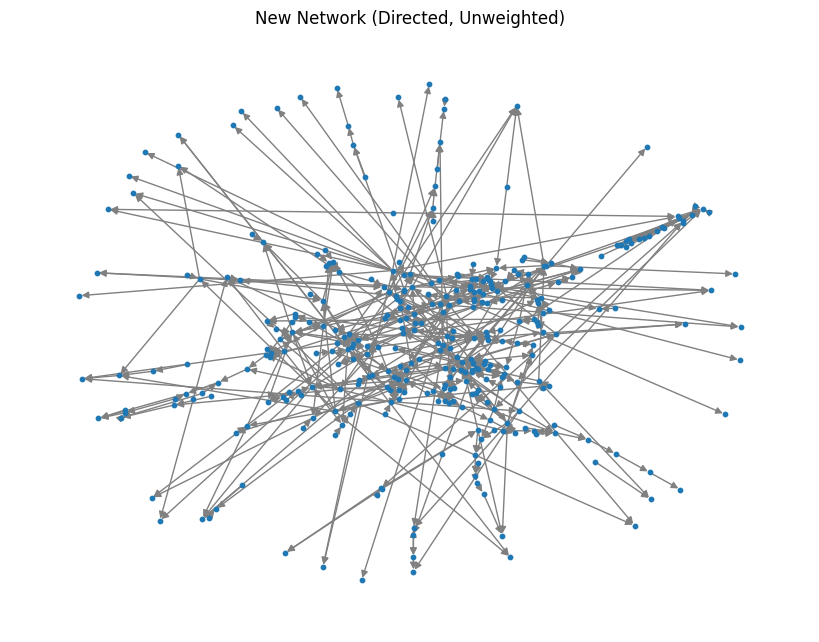

In [30]:
pos = nx.spring_layout(G,seed=42)
print("Number of nodes:",len(G.nodes))
print("Number of edges:",nx.number_of_edges(G))
plt.figure(figsize=(8, 6))
nx.draw(G, pos,
        node_size=10,
        edge_color='gray')
plt.title("New Network (Directed, Unweighted)")
plt.show()

In [31]:
#Connected components
num_components = nx.number_weakly_connected_components(G)
strong_num_components=nx.number_strongly_connected_components(G)
print("Number of weakly connected components:", num_components) #1
print("Number of strongly connected components:", strong_num_components) #219

Number of weakly connected components: 1
Number of strongly connected components: 219


## Centrality Analysis

### Orignal Graph

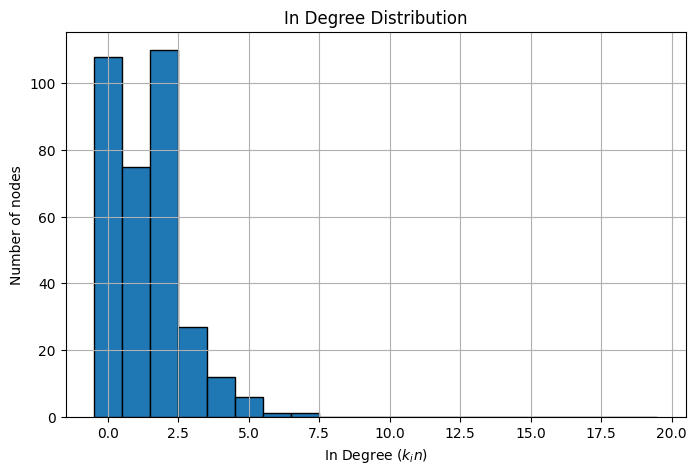

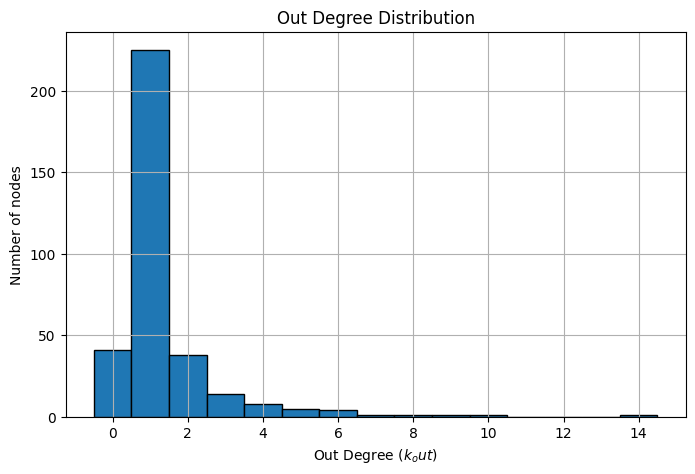

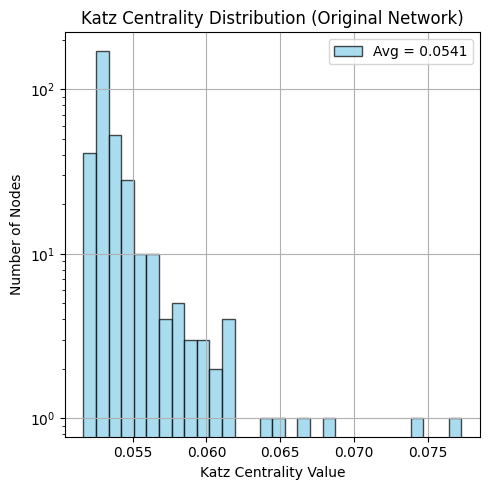

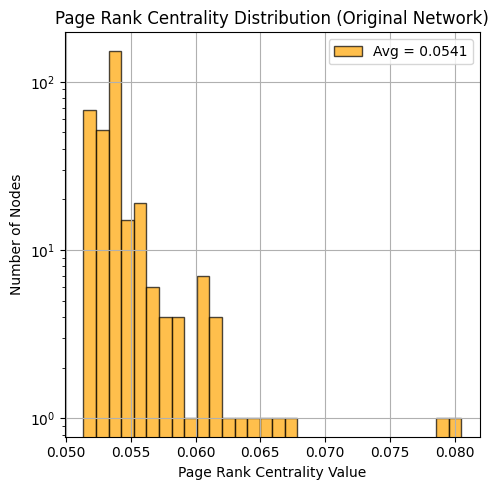

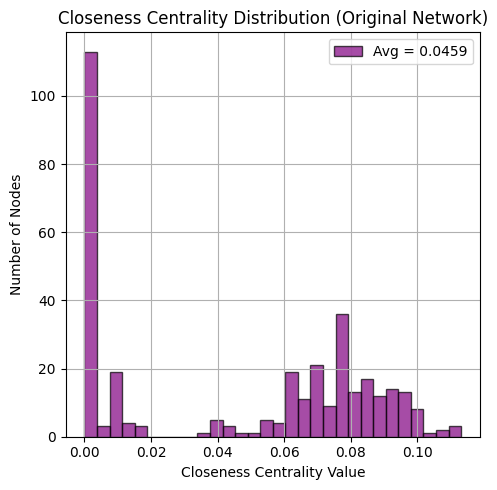

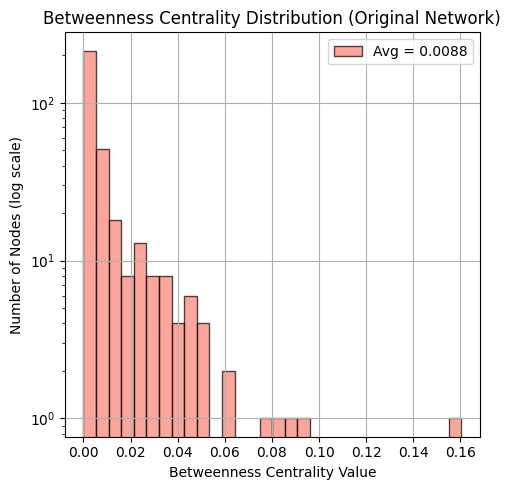

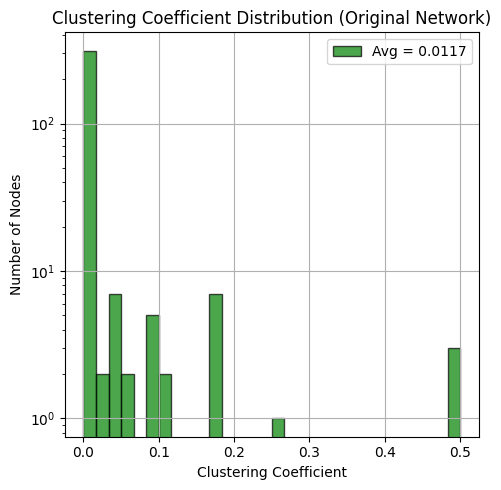

Original Graph Centrality Averages:
  Closeness       : 0.0459
  Betweenness     : 0.0088
  Clustering Coeff: 0.0117


'Averages for Eigen vector, Page Rank and Katz have no physical significance'

In [32]:
kin = np.array([d for n,d in G.in_degree()])
kout= np.array([d for n,d in G.out_degree()])
n = len(kin)

'''Plotting histograms for degree distributions'''
plt.figure(figsize=(8,5))
#In Degree
plt.hist(kin, bins=np.arange(kin.min(), kin.max() + 1) - 0.5, edgecolor='black')
plt.title("In Degree Distribution")
plt.xlabel(r"In Degree $(k_in)$")
plt.ylabel("Number of nodes")
plt.grid(True)
plt.show()

#Out Degree
plt.figure(figsize=(8,5))
plt.hist(kout, bins=np.arange(kout.min(), kout.max() + 1) - 0.5, edgecolor='black')
plt.title("Out Degree Distribution")
plt.xlabel(r"Out Degree $(k_out)$")
plt.ylabel("Number of nodes")
plt.grid(True)
plt.show()

# Use consistent settings
figsize = (5, 5)
dpi = 100

# --- Katz Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
alpha_katz = 0.6
og_custom_katz_vals = katz_centralities(G, alpha_katz)
avg_katz = np.mean(og_custom_katz_vals)
plt.hist(og_custom_katz_vals, bins=30, alpha=0.7, color='skyblue',
         label=f'Avg = {avg_katz:.4f}', edgecolor='black')
plt.title("Katz Centrality Distribution (Original Network)")
plt.xlabel("Katz Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig("katz_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Page Rank Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_custom_pagerank_vals, alpha_pr = page_rank(G)
avg_pagerank = np.mean(og_custom_pagerank_vals)
plt.hist(og_custom_pagerank_vals, bins=30, alpha=0.7, color='orange',
         label=f'Avg = {avg_pagerank:.4f}', edgecolor='black')
plt.title("Page Rank Centrality Distribution (Original Network)")
plt.xlabel("Page Rank Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig("pagerank_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Closeness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_closeness_vals = list(nx.closeness_centrality(G).values())
avg_closeness = np.mean(og_closeness_vals)
plt.hist(og_closeness_vals, bins=30, alpha=0.7, color='purple',
         label=f'Avg = {avg_closeness:.4f}', edgecolor='black')
plt.title("Closeness Centrality Distribution (Original Network)")
plt.xlabel("Closeness Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("closeness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Betweenness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
og_betweenness_vals = list(nx.betweenness_centrality(G).values())
avg_betweenness = np.mean(og_betweenness_vals)
plt.hist(og_betweenness_vals, bins=30, alpha=0.7, color='salmon',
         label=f'Avg = {avg_betweenness:.4f}', edgecolor='black')
plt.title("Betweenness Centrality Distribution (Original Network)")
plt.xlabel("Betweenness Centrality Value")
plt.ylabel("Number of Nodes (log scale)")
plt.yscale('log')  # heavy-tailed distribution
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("betweenness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Clustering Coefficient ---
plt.figure(figsize=figsize, dpi=dpi)
og_clustering_vals = list(nx.clustering(G).values())
avg_clustering = np.mean(og_clustering_vals)
plt.hist(og_clustering_vals, bins=30, alpha=0.7, color='green',
         label=f'Avg = {avg_clustering:.4f}', edgecolor='black')
plt.title("Clustering Coefficient Distribution (Original Network)")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.yscale('log')
plt.savefig("clustering_coefficient_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# Print average values to console
print("Original Graph Centrality Averages:")
# print(f"  Eigenvector     : {avg_eigen:.4f}")
print(f"  Closeness       : {avg_closeness:.4f}")
print(f"  Betweenness     : {avg_betweenness:.4f}")
print(f"  Clustering Coeff: {avg_clustering:.4f}")
'''Averages for Eigen vector, Page Rank and Katz have no physical significance'''

In [33]:
'''Top 3 most central nodes for each type of centrality'''

top_k_nodes(kin,centrality_name="In Degree Centrality")
top_k_nodes(kout,centrality_name="Out Degree Centrality")
top_k_nodes(og_custom_katz_vals, centrality_name="Katz Centrality")
top_k_nodes(og_custom_pagerank_vals, centrality_name="PageRank")
top_k_nodes(og_closeness_vals, centrality_name="Closeness Centrality")
top_k_nodes(og_betweenness_vals, centrality_name="Betweenness Centrality")
top_k_nodes(og_clustering_vals, centrality_name="Clustering Coefficient",reverse=False)


Top 3 nodes by In Degree Centrality:
  SA250 (ID 200) — In Degree Centrality: 20.0000
  SA129 (ID 129) — In Degree Centrality: 7.0000
  CSA3 (ID 44) — In Degree Centrality: 6.0000

Top 3 nodes by Out Degree Centrality:
  CSA29 (ID 17) — Out Degree Centrality: 15.0000
  SA284 (ID 197) — Out Degree Centrality: 14.0000
  CSA1 (ID 1) — Out Degree Centrality: 10.0000

Top 3 nodes by Katz Centrality:
  CSA29 (ID 17) — Katz Centrality: 0.0773
  SA284 (ID 197) — Katz Centrality: 0.0742
  CSA1 (ID 1) — Katz Centrality: 0.0684

Top 3 nodes by PageRank:
  CSA29 (ID 17) — PageRank: 0.0805
  SA284 (ID 197) — PageRank: 0.0790
  SA58 (ID 7) — PageRank: 0.0675

Top 3 nodes by Closeness Centrality:
  SA39 (ID 247) — Closeness Centrality: 0.1133
  SA129 (ID 129) — Closeness Centrality: 0.1130
  SA31 (ID 59) — Closeness Centrality: 0.1114

Top 3 nodes by Betweenness Centrality:
  CSA29 (ID 17) — Betweenness Centrality: 0.1603
  CSA27 (ID 35) — Betweenness Centrality: 0.0918
  SA129 (ID 129) — Betweennes

### Configuration Model 

In [34]:
noofgraphs = 100
v_0 = np.zeros(n)
v_0[0]=1
top_node_diff_centralities = np.zeros((5, noofgraphs))
summary = []

# For computing the average centrality value for each node across all generated random graphs
avg_katz_overall=np.zeros(len(G.nodes))
avg_pagerank_overall=np.zeros(len(G.nodes))
avg_closeness_overall=np.zeros(len(G.nodes))
avg_betweenness_overall=np.zeros(len(G.nodes))
avg_clustering_overall=np.zeros(len(G.nodes))


fig, axes = plt.subplots(noofgraphs, 5, figsize=(20, 5 * noofgraphs))  
for i in tqdm(range(noofgraphs), total=noofgraphs):
    D = non_multi_config_model(G)

    '''1. Katz Centrality'''
    alpha_katz = 0.6
    custom_katz = katz_centralities(G, alpha_katz)

    avg_katz = np.mean(custom_katz)
    top_node_diff_centralities[0][i] = np.argmax(custom_katz)
    avg_katz_overall+=custom_katz/noofgraphs

    # #Plotting
    # axes[i][0].hist(custom_katz, alpha=0.6, label=f'Avg={avg_katz:.4f}')
    # axes[i][0].legend()
    # axes[i][0].set_title(f"Katz - Graph {i+1}")

    #Computing Jensen Shanon Distance
    array1=og_custom_katz_vals
    array2=custom_katz
    js_katz,distribution,bin_edges=Jensen_Shanon_for_arrays(array1,array2,log_bins=False)
    ks_katz=stats.ks_2samp(array1,array2)

    # Use bar to mimic histogram bins
    axes[i][0].bar(
        bin_edges[:-1],               # left edges of bins
        distribution,                 # heights
        width=np.diff(bin_edges),     # bin widths
        align='edge',                 # so bars start at bin_edges
        alpha=0.8,
        color='b',
        label="Distribution"
    )

    axes[i][0].set_xscale('log')
    axes[i][0].set_yscale('log')
    axes[i][0].set_xlabel("Centrality Value")
    axes[i][0].set_ylabel("Probability")
    axes[i][0].set_title(f"JS Dist. Katz - Graph {i+1}")
    # axes[i][0].set_xlim(6.0*(1e-2), 6.1*(1e-2))   # works nicely with log scale
    axes[i][0].legend()

    '''2. Page Rank Centrality'''
    custom_pagerank_vals, alpha_pr = page_rank(G)
    avg_page = np.mean(custom_pagerank_vals)
    top_node_diff_centralities[1][i] = np.argmax(custom_pagerank_vals)
    avg_pagerank_overall+=custom_pagerank_vals/noofgraphs

    #Plotting
    axes[i][1].hist(custom_pagerank_vals, alpha=0.7, color='skyblue', label=f'Avg = {avg_page:.4f}')
    axes[i][1].legend()
    axes[i][1].set_title(f"Page Rank - Graph {i+1}")
    
    #Computing Jensen Shanon Distance
    array1=og_custom_pagerank_vals
    array2=custom_pagerank_vals
    js_pagerank,distribution,bin_edges=Jensen_Shanon_for_arrays(array1,array2,log_bins=False)
    ks_pagerank=stats.ks_2samp(array1,array2)

    '''3. Closeness Centrality'''
    closeness_vals = np.array(list(nx.closeness_centrality(D).values()))
    avg_closeness = np.mean(closeness_vals)
    top_node_diff_centralities[2][i] = np.argmax(closeness_vals)
    avg_closeness_overall+=closeness_vals/noofgraphs

    #Plotting
    axes[i][2].hist(closeness_vals, alpha=0.7, color='skyblue', label=f'Avg = {avg_closeness:.4f}')
    axes[i][2].legend()
    axes[i][2].set_title(f"Closeness - Graph {i+1}")
    
    #Computing Jensen Shanon Distance
    array1=og_closeness_vals
    array2=closeness_vals
    js_closeness,distribution,bin_edges=Jensen_Shanon_for_arrays(array1,array2,log_bins=False)
    ks_closeness=stats.ks_2samp(array1,array2)

    '''4. Betweenness Centrality'''
    betweenness_vals = np.array(list(nx.betweenness_centrality(D).values()))
    avg_betweenness = np.mean(betweenness_vals)
    top_node_diff_centralities[3][i] = np.argmax(betweenness_vals)
    avg_betweenness_overall+=betweenness_vals/noofgraphs
    
    #Plotting
    axes[i][3].hist(betweenness_vals, alpha=0.7, color='salmon', label=f'Avg = {avg_betweenness:.4f}')
    axes[i][3].legend()
    axes[i][3].set_title(f"Betweenness - Graph {i+1}")

    #Computing Jensen Shanon Distance
    array1=og_betweenness_vals
    array2=betweenness_vals
    js_betweenness,distribution,bin_edges=Jensen_Shanon_for_arrays(array1,array2,log_bins=False)
    ks_betweenness=stats.ks_2samp(array1,array2)

    '''5. Local Clustering Coefficient'''
    clustering_vals = np.array(list(nx.clustering(D).values()))
    avg_clustering_overall+=clustering_vals/noofgraphs
    avg_clustering = np.mean(clustering_vals)
    axes[i][4].set_title(f"Clustering Coeff. - Graph {i+1}")
    top_node_diff_centralities[4][i] = np.argmax(clustering_vals)

    #Plotting
    axes[i][4].hist(clustering_vals, alpha=0.7, color='green', edgecolor='black', label=f'Avg = {avg_clustering:.4f}')
    axes[i][4].legend()

    #Computing Jensen Shanon Distance
    array1=og_clustering_vals
    array2=clustering_vals
    js_clustering,distribution,bin_edges=Jensen_Shanon_for_arrays(array1,array2,log_bins=False)
    ks_clustering=stats.ks_2samp(array1,array2)

    # Storing summary for later

    summary.append({
        "Graph": i + 1,
        "Katz Avg": avg_katz,
        "JS Katz": js_katz,
        "KS Katz": ks_katz,
        "PageRank Avg": avg_page,
        "JS PageRank": js_pagerank,
        "KS PageRank": ks_pagerank,
        "Closeness Avg": avg_closeness,
        "JS Closeness": js_closeness,
        "KS Closeness": ks_closeness,
        "Betweenness Avg": avg_betweenness,
        "JS Betweenness": js_betweenness,
        "KS Betweenness": ks_betweenness,
        "Clustering Avg": avg_clustering,
        "JS Clustering": js_clustering,
        "KS Clustering": ks_clustering,
    })

plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


In [35]:
# Creating summary table
summary_df = pd.DataFrame(summary)
summary_df = summary_df.round(4).to_string(index=False)

print("\nSummary of Centrality Averages and Jensen-Shannon Distances:\n")
print(summary_df)


Summary of Centrality Averages and Jensen-Shannon Distances:

 Graph  Katz Avg  JS Katz                                       KS Katz  PageRank Avg  JS PageRank                                   KS PageRank  Closeness Avg  JS Closeness                                  KS Closeness  Betweenness Avg  JS Betweenness                                KS Betweenness  Clustering Avg  JS Clustering                              KS Clustering
     1    0.0541   0.2656 (0.25806451612903225, 2.1917781407330997e-10)        0.0540       0.2080 (0.17008797653958943, 0.00010049355869317195)         0.0439        0.1567   (0.10263929618768329, 0.055007181026641705)           0.0064          0.2960    (0.08797653958944282, 0.14283958944762226)          0.0042         0.6516   (0.03519061583577713, 0.984435964650025)
     2    0.0541   0.2787  (0.20821114369501467, 6.970459525600844e-07)        0.0541       0.1807 (0.17008797653958943, 0.00010049355869317195)         0.0380        0.3460  (0.2404692082111

In [36]:
avg=0
for i in summary:
    avg+=i["KS Clustering"][0]/100

print(avg)

0.044310850439882726


In [37]:
### Comparing the average centrality value of each node across all generated random graphs with that of the original graph

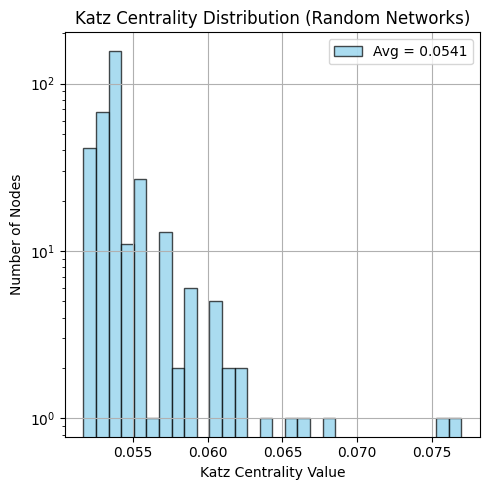

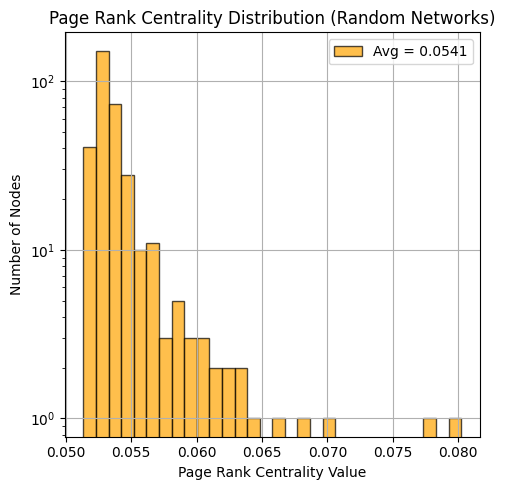

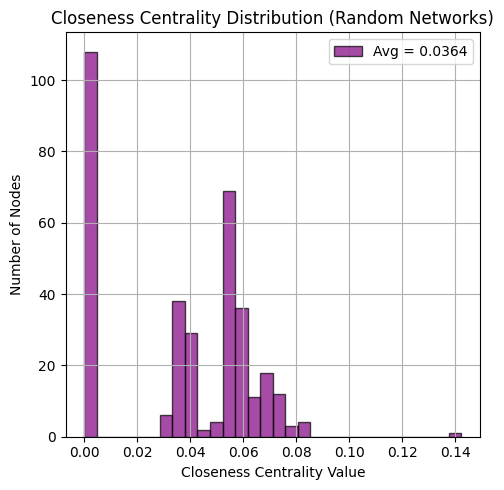

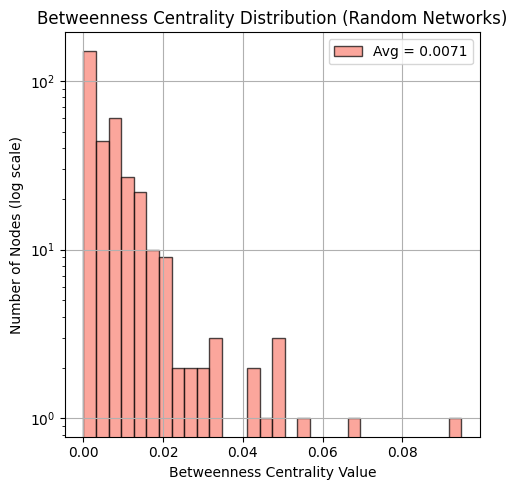

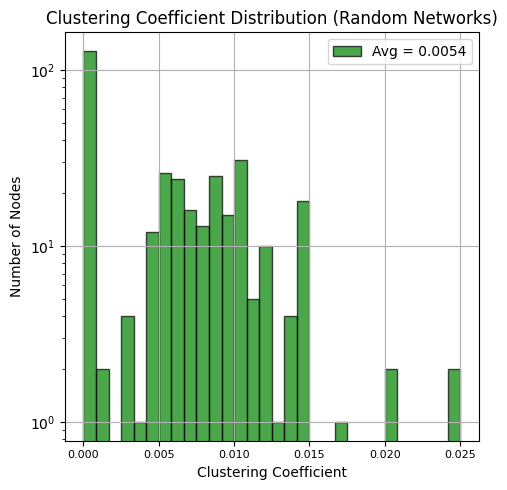

Original Graph Centrality Averages:
  Closeness       : 0.0364
  Betweenness     : 0.0071
  Clustering Coeff: 0.0054


'Averages for Eigen vector, Page Rank and Katz have no physical significance'

In [38]:
# Use consistent settings
figsize = (5, 5)
dpi = 100

# --- Katz Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
alpha_katz = 0.6
avg_katz = np.mean(avg_katz_overall)
plt.hist(avg_katz_overall, bins=30, alpha=0.7, color='skyblue',
         label=f'Avg = {avg_katz:.4f}', edgecolor='black')
plt.title("Katz Centrality Distribution (Random Networks)")
plt.xlabel("Katz Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig("katz_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Page Rank Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
avg_pagerank = np.mean(avg_pagerank_overall)
plt.hist(avg_pagerank_overall, bins=30, alpha=0.7, color='orange',
         label=f'Avg = {avg_pagerank:.4f}', edgecolor='black')
plt.title("Page Rank Centrality Distribution (Random Networks)")
plt.xlabel("Page Rank Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.yscale('log')
plt.grid()
plt.tight_layout()
plt.savefig("pagerank_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Closeness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
avg_closeness = np.mean(avg_closeness_overall)
plt.hist(avg_closeness_overall, bins=30, alpha=0.7, color='purple',
         label=f'Avg = {avg_closeness:.4f}', edgecolor='black')
plt.title("Closeness Centrality Distribution (Random Networks)")
plt.xlabel("Closeness Centrality Value")
plt.ylabel("Number of Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("closeness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Betweenness Centrality ---
plt.figure(figsize=figsize, dpi=dpi)
avg_betweenness = np.mean(avg_betweenness_overall)
plt.hist(avg_betweenness_overall, bins=30, alpha=0.7, color='salmon',
         label=f'Avg = {avg_betweenness:.4f}', edgecolor='black')
plt.title("Betweenness Centrality Distribution (Random Networks)")
plt.xlabel("Betweenness Centrality Value")
plt.ylabel("Number of Nodes (log scale)")
plt.yscale('log')  # heavy-tailed distribution
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("betweenness_centrality_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# --- Clustering Coefficient ---
plt.figure(figsize=figsize, dpi=dpi)
avg_clustering = np.mean(avg_clustering_overall)
plt.hist(avg_clustering_overall, bins=30, alpha=0.7, color='green',
         label=f'Avg = {avg_clustering:.4f}', edgecolor='black')
plt.title("Clustering Coefficient Distribution (Random Networks)")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Number of Nodes")
plt.xticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.yscale('log')
plt.savefig("clustering_coefficient_original.png", dpi=dpi, bbox_inches="tight")
plt.show()

# Print average values to console
print("Original Graph Centrality Averages:")
# print(f"  Eigenvector     : {avg_eigen:.4f}")
print(f"  Closeness       : {avg_closeness:.4f}")
print(f"  Betweenness     : {avg_betweenness:.4f}")
print(f"  Clustering Coeff: {avg_clustering:.4f}")
'''Averages for Eigen vector, Page Rank and Katz have no physical significance'''

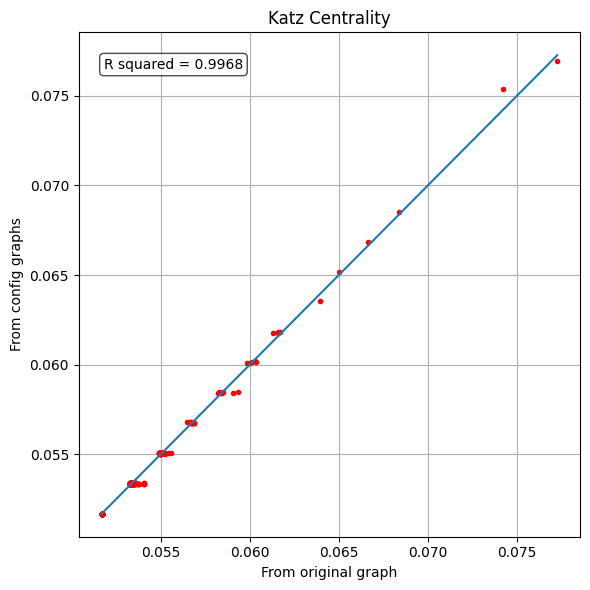

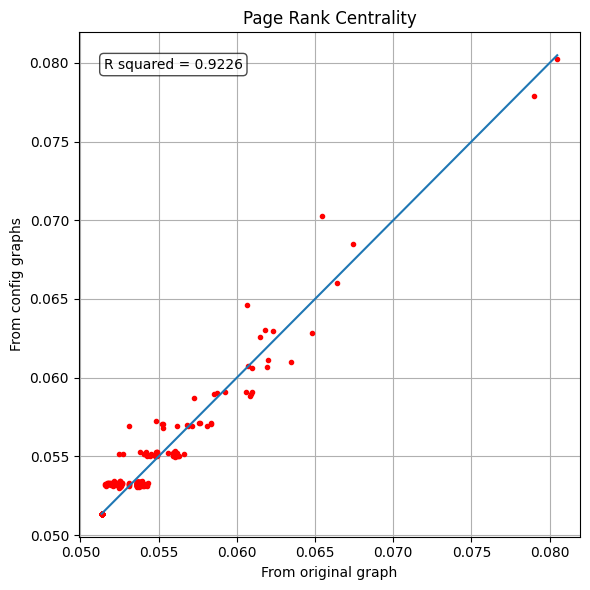

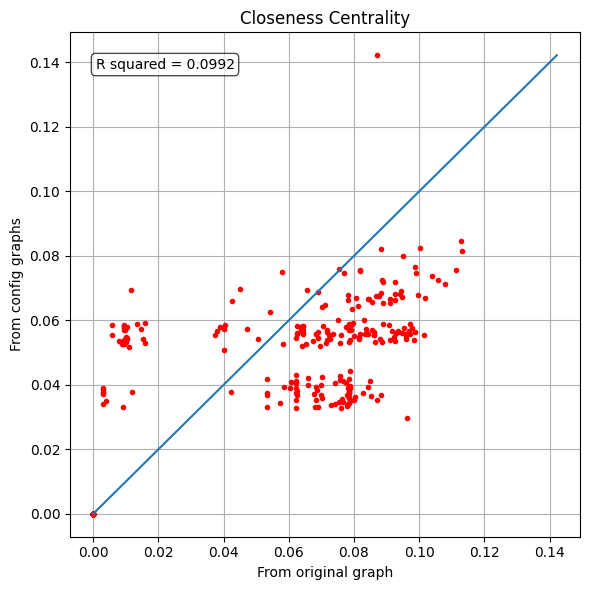

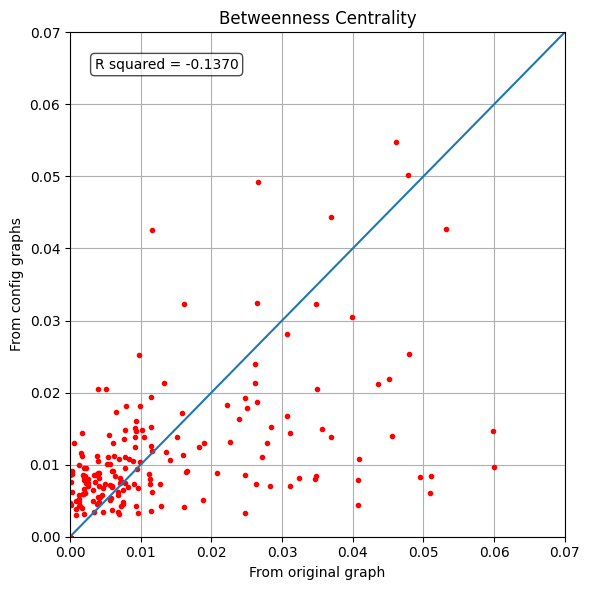

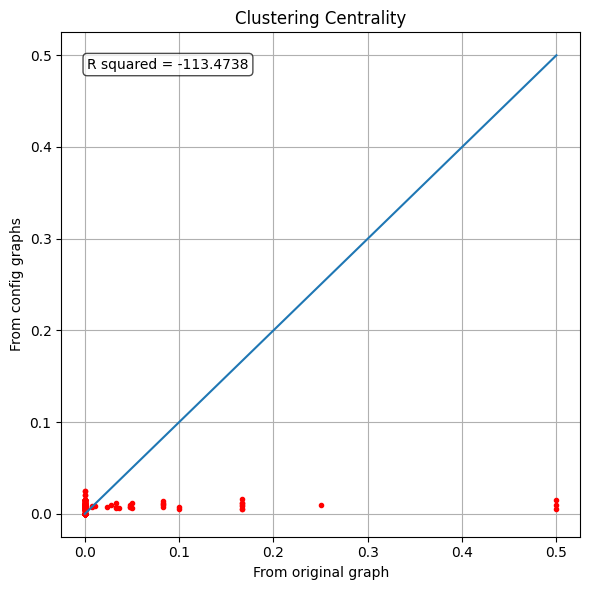

In [39]:
def plot_comparison(array1, array2, title, xlabel, ylabel, filename, xlim=None, ylim=None):
    plt.figure(figsize=(6,6))
    coords = np.column_stack((array1, array2))
    
    plt.plot(coords[:,0], coords[:,1], "ro", markersize=3)
    minim = min(min(coords[:,0]), min(coords[:,1]))
    maxim = max(max(coords[:,0]), max(coords[:,1]))
    plt.plot([minim, maxim], [minim, maxim])

    Rsquaredval = R_squared(array2, array1)
    plt.text(0.05, 0.95, f'R squared = {Rsquaredval:.4f}',
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)   # save each individually
    plt.show()


# Now call for each case
plot_comparison(og_custom_katz_vals, avg_katz_overall,
                "Katz Centrality", "From original graph", "From config graphs",
                "katz_nodes.png")

plot_comparison(og_custom_pagerank_vals, avg_pagerank_overall,
                "Page Rank Centrality", "From original graph", "From config graphs",
                "pagerank_nodes.png")

plot_comparison(og_closeness_vals, avg_closeness_overall,
                "Closeness Centrality", "From original graph", "From config graphs",
                "closeness_nodes.png")

plot_comparison(og_betweenness_vals, avg_betweenness_overall,
                "Betweenness Centrality", "From original graph", "From config graphs",
                "betweenness_nodes.png",
                xlim=(0,0.07), ylim=(0,0.07))

plot_comparison(og_clustering_vals, avg_clustering_overall,
                "Clustering Centrality", "From original graph", "From config graphs",
                "clustering_nodes.png")


### Summary 

In [40]:
katz_avg=0
pagerank_avg=0
closeness_avg=0
betweeness_avg=0
clustering_avg=0

for graph in summary:
    katz_avg+=graph["Katz Avg"]/noofgraphs
    pagerank_avg+=graph["PageRank Avg"]/noofgraphs
    closeness_avg+=graph["Closeness Avg"]/noofgraphs
    betweeness_avg+=graph["Betweenness Avg"]/noofgraphs
    clustering_avg+=graph["Clustering Avg"]/noofgraphs

print("Random Graph Centrality Average averages:")
print(f"  Katz            : {katz_avg:.4f}")
print(f"  Page Rank       : {pagerank_avg:.4f}")
print(f"  Closeness       : {closeness_avg:.4f}")
print(f"  Betweenness     : {betweeness_avg:.4f}")
print(f"  Clustering Coeff: {clustering_avg:.4f}")

Random Graph Centrality Average averages:
  Katz            : 0.0541
  Page Rank       : 0.0541
  Closeness       : 0.0364
  Betweenness     : 0.0071
  Clustering Coeff: 0.0054


In [41]:
most_central_config=[]
node_order=list(G.nodes)
for i in top_node_diff_centralities:
    unique_elements, counts = np.unique(i, return_counts=True)
    mode_index = np.argmax(counts)
    mode_value = unique_elements[int(mode_index)]
    mode_value=node_order[int(mode_value)]
    most_central_config.append(Node_meta[mode_value])

print(most_central_config)

['CSA29', 'CSA29', 'SA250', 'CSA29', 'SA109']


### Testing the Jensen-Shannon distance between Katz centrality distributions of the original graph and the last generated random graph for different bin sizes

In [42]:
# JSD_list=[]
# for i in range(1,10000):
#     array1=og_custom_katz
#     array2=custom_katz
#     JSD=Jensen_Shanon_for_arrays(array1,array2,number_bins=i)
#     JSD_list.append(float(JSD))

# plt.plot(JSD_list)
# plt.grid()
# plt.xlabel("Number of Bins")
# plt.ylabel("Jensen-Shanon Divergence")
# plt.show()